# Mean-field limits to approximate master equations

One shortcoming of the master equation is that its complexity scales with the number of states available to the system. What if that number goes to infinity? Even for a simple birth-death process of bacteria, it might be possible for the population to grown into the billions or more. Do we have to track all of these equations?

Here, we explain an approach that approximates ensemble of states far from important absorbing states as a mean-field limit. Consider a simple SIS process where we might be tracking the number $n$ of infected individuals in a population. It might be important track individual states when $n$ is close to the $n=0$ absorbing state, but once $n$ is greater than some criterion $n_c$ (say 100) than perhaps we care less about the discrete nature of the count of individuals and can approximate states with $n>n_c$ as a mean-field quantity $I(t)$. 

We call this approach the mean-field limit of approximate master equations, or mean-FLAME. Conceptually, we are then tracking a system of states where one state is allowed to move as mean-field quantity, like so:

![mean-flame_schematic](assets/png/meanFLAME.png)

![](https://drive.google.com/uc?export=view&id=1hAWw4O3lCf6M0A5rJbvjkEHoWpsnNmXt)

# Birth-death process

We first write a classic master equation model. While the master equation applies for all values of active particles *n*, we write limiting cases for *n=0* and for some arbitrary large maximum *N*. That way, we can store the occupation number in a simple array of finite size and know that we will never try to look up the value of the array at *-1* or *N+1*.

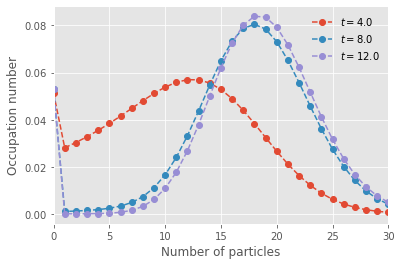

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

# We will use the odeint routine
from scipy.integrate import odeint

# Full master equation
def J(x, t, mu, nu):
    """
    Time derivative of the occupation numbers.
        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
    """

    dx = 0*x
    for n in range(len(x)):
        if n==0: #for first state
            dx[0] = nu*x[1]
        elif n==len(x)-1: #for last state
            dx[n] = -(nu*n*n)*x[n] + mu*(n-1)*x[n-1]
        else: #all other states
            dx[n] = -(mu*n+nu*n*n)*x[n] + nu*(n+1)*(n+1)*x[n+1] + mu*(n-1)*x[n-1]

    return dx

# Time of observations
t_length = 12
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 100
x_0 = np.zeros(nb_of_states)
x_0[1] = 1

# Parameters
mu = 1.00
nu = 0.05

# Numerical integration
G = lambda x, t: J(x, t, mu, nu)
x_path = odeint(G, x_0, t_vec)

# Plot
for t in range(t_steps):
    if t>0:
      plt.plot(range(nb_of_states),x_path[t], marker="o", ls='--', label=fr"$t = {t_vec[t]}$")
plt.legend(frameon=False)
plt.ylabel('Occupation number')
plt.xlabel('Number of particles')
plt.xlim([0, 30])
plt.show()

We now write the mean-FLAME system for the same model. We use the exact logic but smaller value of $N$ to leverage the computational efficiency of mean-FLAME and instead add two extra states for the occupation number and position of the mean-field limit that approximates all states beyond $N$.

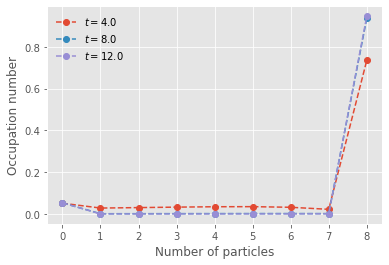

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

# We will use the odeint routine
from scipy.integrate import odeint
# and a Poisson approximation
from scipy.stats import poisson

# Master Equations
def meanFLAME(x, t, mu, nu):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
    """

    dx = 0*x
    for n in range(len(x)):
        if n==0: #for first master equation state
            dx[0] = - mu*n*x[0] + nu*x[1]
        elif n==len(x)-3: #for last master equation state
            dx[n] = -(nu*n*n)*x[n] + mu*(n-1)*x[n-1] - mu*n*x[n] + nu*(n+1)*(n+1)*poisson.pmf(n+1, x[n+2])*x[n+1]/(1-poisson.cdf(n,x[n+2]))
        elif n==len(x)-2: #for occupation number of the mean-field limit
            dx[n] = mu*(n-1)*x[n-1] - nu*n*n*poisson.pmf(n, x[n+1])*x[n]/(1-poisson.cdf(n-1,x[n+1]))
        elif n==len(x)-1: #for the position of the mean-field limit
            if x[n-1]>0:
              dx[n] = mu*x[n]-nu*x[n]*x[n]
            else:
              dx[n] = 0
        else: #all other states
            dx[n] = -(mu*n+nu*n*n)*x[n] + nu*(n+1)*(n+1)*x[n+1] + mu*(n-1)*x[n-1]

    return dx

# Time of observations
t_length = 12
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states_hybrid = 10
x_0 = np.zeros(nb_of_states_hybrid)
x_0[1] = 1
x_0[-1] = nb_of_states_hybrid-1

# Parameters
mu = 1.00
nu = 0.05

# Integration
G = lambda x, t: meanFLAME(x, t, mu, nu)
y_path = odeint(G, x_0, t_vec)

# Plot
for t in range(t_steps):
    if t>0:
      plt.plot(range(nb_of_states_hybrid-1),y_path[t][0:-1], marker="o", ls='--', label=fr"$t = {t_vec[t]}$")
      plt.legend(frameon=False)
plt.ylabel('Occupation number')
plt.xlabel('Number of particles')
plt.show()

We now compare the master equation and mean-FLAME approach by assuming some distribution (here a Poisson) around the mean-field limit.

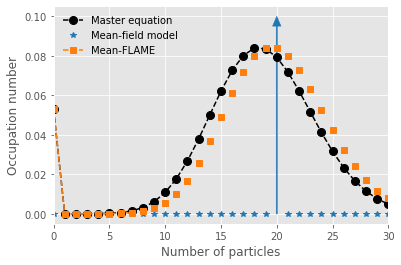

In [3]:
#Comparison
kwargs = {'color':'tab:blue','linestyle':'solid'}
plt.arrow(y_path[t_steps-1][-1], 0, 0, 0.095, width=0.1, head_width=0.75, head_length=0.005, **kwargs)
p = plt.plot(range(nb_of_states-1),x_path[t_steps-1][0:-1], marker="o", markersize=8, ls='--', color='black',label=fr"Master equation")
p = plt.plot(range(20),np.zeros(20),marker="*", color='tab:blue',linewidth=0,label=fr'Mean-field model')
p = plt.plot(range(21,31),np.zeros(10),marker="*", color='tab:blue',linewidth=0,label=None)
p = plt.plot(range(nb_of_states_hybrid-2),y_path[t_steps-1][0:-2], color = 'tab:orange', marker="s", ls='--', label=fr"Mean-FLAME")
for n in np.arange(nb_of_states_hybrid-2,nb_of_states-1):
  p = plt.plot(n,poisson.pmf(n, y_path[t_steps-1][-1])*y_path[t_steps-1][-2]/(1-poisson.cdf(nb_of_states_hybrid-3,y_path[t_steps-1][-1])), marker="s", color=p[-1].get_color(), ls='None')

plt.xlim([0, 30])
plt.legend(frameon=False)
plt.ylabel('Occupation number')
plt.xlabel('Number of particles')
plt.show()

# Coupled birth-death processes

In [5]:
#We use odeintw for integration of two-dimensional systems
!pip install odeintw

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# We will use the odeint routine
from scipy.integrate import odeint
# With a wrapper to facilitate 2d arrays
from odeintw import odeintw

# Master equation
@jit(nopython=True)
def J2(x, t, mu, nu, lamb):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
        * lamb is the coupling rate (linear lambda)
    """

    dx = 0*x
    for n1, n2 in np.ndindex(x.shape):

        dx[n1,n2] = -(mu*n1+n2*lamb+nu*n1*n1)*x[n1,n2] - (mu*n2+n1*lamb+nu*n2*n2)*x[n1,n2]
        if(n1<x.shape[0]-1):
          dx[n1,n2] += nu*(n1+1)*(n1+1)*x[n1+1,n2]
        if(n1>0):
          dx[n1,n2] += (mu*(n1-1)+n2*lamb)*x[n1-1,n2]
        if(n2<x.shape[1]-1):
          dx[n1,n2] += nu*(n2+1)*(n2+1)*x[n1,n2+1]
        if(n2>0):
          dx[n1,n2] += (mu*(n2-1)+n1*lamb)*x[n1,n2-1]

    return dx

# Time of observations
t_length = 100
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 50
x_0 = np.zeros((nb_of_states,nb_of_states))
x_0[1,1] = 1

# Parameters
mu = 1.00
nu = 0.1
lamb = 0.00

# Integration
G = lambda x, t: J2(x, t, mu, nu, lamb)
x_path = odeintw(G, x_0, t_vec)

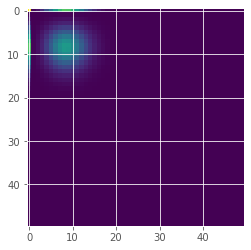

In [7]:
#Visualization of the occupation numbers in 2d
plt.imshow(x_path[-1])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

# We will use the odeint routine
from scipy.integrate import odeint
# and a Poisson approximation
from scipy.stats import poisson

# mean-FLAME
def meanFLAME2(x, t, mu, nu, lamb):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
        * lamb is the coupling rate (linear lambda)
    """

    dx = 0*x

    theta = x[len(x)-2]*x[len(x)-1]
    for k in range(int(len(x)/2), len(x)-2):
      theta += (k-len(x)/2)*x[k]
    theta = theta*lamb
    for n in range(int(len(x)/2)):
        if n==0: #for first master equation state
            dx[0] = - (mu*n+theta)*x[0] + nu*x[1]
        elif n==int(len(x)/2)-3: #for last master equation state
            dx[n] = -(nu*n*n)*x[n] + (mu*(n-1)+theta)*x[n-1] - (mu*n+theta)*x[n] + nu*(n+1)*(n+1)*poisson.pmf(n+1, x[n+2])*x[n+1]/(1-poisson.cdf(n,x[n+2]))
        elif n==int(len(x)/2)-2: #for occupation number of mean-field limit
            dx[n] = (mu*(n-1)+theta)*x[n-1] - nu*n*n*poisson.pmf(n, x[n+1])*x[n]/(1-poisson.cdf(n-1,x[n+1]))
        elif n==int(len(x)/2)-1: #for the position of the mean-field limit
            if x[n-1]>0:
              dx[n] = (mu*x[n]+theta)-nu*x[n]*x[n]
            else:
              dx[n] = 0
        else: #all other states
            dx[n] = -(mu*n+theta+nu*n*n)*x[n] + nu*(n+1)*(n+1)*x[n+1] + (mu*(n-1)+theta)*x[n-1]

    theta = x[int(len(x)/2)-2]*x[int(len(x)/2)-1]
    for k in range(0, int(len(x)/2)-2):
      theta += k*x[k]
    theta = theta*lamb
    for k in range(int(len(x)/2), len(x)):
        n = k - len(x)/2
        if n==0: #for first master equation state
            dx[k] = - (mu*n+theta)*x[k] + nu*x[k+1]
        elif k==len(x)-3: #for last master equation state
            dx[k] = -(nu*n*n)*x[k] + (mu*(n-1)+theta)*x[k-1] - (mu*n+theta)*x[k] + nu*(n+1)*(n+1)*poisson.pmf(n+1, x[k+2])*x[k+1]/(1-poisson.cdf(n,x[k+2]))
        elif k==len(x)-2: #for occupation number of mean-field limit
            dx[k] = (mu*(n-1)+theta)*x[k-1] - nu*n*n*poisson.pmf(n, x[k+1])*x[k]/(1-poisson.cdf(n-1,x[k+1]))
        elif k==len(x)-1: #for the position of the mean-field limit
            if x[k-1]>0:
              dx[k] = (mu*x[k]+theta)-nu*x[k]*x[k]
            else:
              dx[k] = 0
        else: #all other states
            dx[k] = -(mu*n+theta+nu*n*n)*x[k] + nu*(n+1)*(n+1)*x[k+1] + (mu*(n-1)+theta)*x[k-1]

    return dx

# Time of observations
t_length = 100
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states_hybrid = 10
x_0 = np.zeros(2*nb_of_states_hybrid)
x_0[1] = 1
x_0[nb_of_states_hybrid-1] = nb_of_states_hybrid-1
x_0[nb_of_states_hybrid] = 1
x_0[-1] = nb_of_states_hybrid-1

# Parameters
mu = 1.00
nu = 0.1
lamb = 0.00

# Integration
G = lambda x, t: meanFLAME2(x, t, mu, nu, lamb)
y_path = odeint(G, x_0, t_vec)

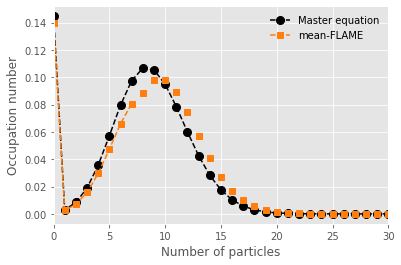

In [10]:
#Comparison
p = plt.plot(range(nb_of_states),x_path[t_steps-1].sum(axis=1), marker="o", markersize=8, ls='--', color='black',label=fr"Master equation")
p = plt.plot(range(nb_of_states_hybrid-2),y_path[t_steps-1][0:8], color = 'tab:orange', marker="s", ls='--', label=fr"mean-FLAME")
for n in np.arange(nb_of_states_hybrid-2,nb_of_states-1):
  p = plt.plot(n,poisson.pmf(n, y_path[t_steps-1][9])*y_path[t_steps-1][8]/(1-poisson.cdf(nb_of_states_hybrid-3,y_path[t_steps-1][9])), marker="s", color=p[-1].get_color(), ls='None')

plt.xlim([0, 30])
plt.legend(frameon=False)
plt.ylabel('Occupation number')
plt.xlabel('Number of particles')
plt.show()